# Begin With A little Data Munging

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def edit_df(filename):
    df =  pd.read_csv(filename, header=None)
    df = df.rename(columns = {0: "v_x", 1:"v_y", 2:"v_z"})
    step = df.index.values
    df['step'] = step
    df['v_x'] = df['v_x'].apply(lambda x: float(x.strip('gvel: '))).values
    df['v_norm'] = np.sqrt(df['v_x'].values**2 + df['v_z'].values**2)
    return df

In [2]:
df = edit_df("ramp45velocitiesblock01.txt")
df.head()

,v_x,v_y,v_z,step,v_norm
0,0.000,0.0,0.000,0,0.000000
1,0.000,0.0,-0.049,1,0.049000
2,0.037,-0.0,-0.052,2,0.063820
3,0.068,-0.0,-0.064,3,0.093381
4,0.095,-0.0,-0.080,4,0.124197


# Plot the X, Z components and Magnitude

In [3]:
def plot_vel_components(df, angle, friction):
    fig, ax = plt.subplots()
    ax.plot(df["step"].values, df["v_x"].values, label="v_x")
    ax.plot(df["step"].values, df["v_z"].values, label="v_z")
    ax.plot(df["step"].values, df["v_norm"].values, label="v_norm")
    ax.legend()
    ax.set_title("Block on {} degree Ramp; μ = {}".format(angle, friction))
    ax.set_ylabel("velocity")
    ax.set_xlabel("timestep");

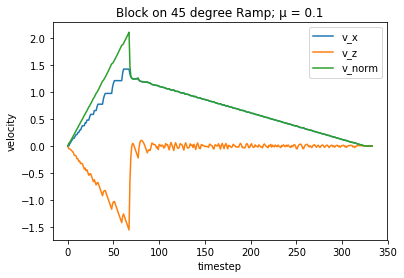

In [4]:
plot_vel_components(df, "45", "0.1")

# Calculate Friction Coefficient

Let's try to fit a line through v_norm using linear regression. First we need to determine exact timestep where the block exits the ramp.

In [5]:
def find_exit_time(df):
    prev_vel = -1*float("inf")
    v = df["v_norm"].values
    for i, vel in enumerate(v):
        if vel < prev_vel:
            print("Velocity decreasing at timestep {}".format(i))
            print("Velocity went from {:0.4f} to {:0.4f}".format(prev_vel, vel))
            return i
        prev_vel = vel

i = find_exit_time(df)

Velocity decreasing at timestep 68
Velocity went from 2.1021 to 1.4750


In [6]:
def fit_line(df, i):
    step_ramp = df.iloc[0:i]["step"].values.reshape(-1, 1)
    v_ramp = df.iloc[0:i] ["v_norm"].values.reshape(-1, 1)
    from sklearn.linear_model import LinearRegression
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(step_ramp, v_ramp)  # perform linear regression
    v_pred = linear_regressor.predict(step_ramp)  # make predictions
    fig, ax = plt.subplots()
    ax.scatter(step_ramp, v_ramp)
    ax.plot(step_ramp, v_pred, color='red')
    ax.set_title("Velocities on Ramp with Best Fit Line")
#     plt.show()
    a = linear_regressor.coef_[0][0]/0.005 # to convert from m/timestep^2 to m/s^2, divide by number of timesteps per second as specified in model (default is 0.01)
    print("The block fell down the ramp with an acceleration of {:0.4f} m/s^2".format(a))
    
    return a

The block fell down the ramp with an acceleration of 6.2456 m/s^2


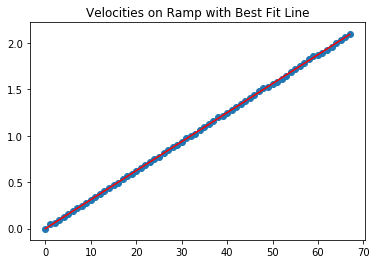

In [7]:
a = fit_line(df, i)

It can easily be shown that μ = a/g*sec(θ) - tan(θ)

In [8]:
def calc_experimental_mu(a, theta):
    g = 9.801
    mu = a/(g *np.cos(theta)) - np.sin(theta)/np.cos(theta)
    return mu

mu = calc_experimental_mu(a, np.pi/4)
print("The experimental mu is {:0.4f}".format(mu))

The experimental mu is -0.0988


Friction coefficient should not be negative.

### Calculate Percent Difference

In [9]:
pdiff = abs(0.1 - abs(mu)) *100/ abs(mu)
print("{:0.4f}%".format(pdiff))

1.2070%


# Repeat For Frictionless Ramp

Calculated acceleration does not a appear accurate.

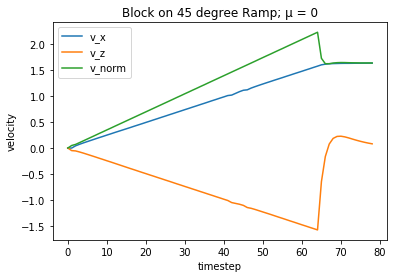

In [10]:
df = edit_df("ramp45velocitiesblock00.txt")
plot_vel_components(df, "45", "0")

Velocity decreasing at timestep 65
Velocity went from 2.2196 to 1.7197
The block fell down the ramp with an acceleration of 6.9327 m/s^2


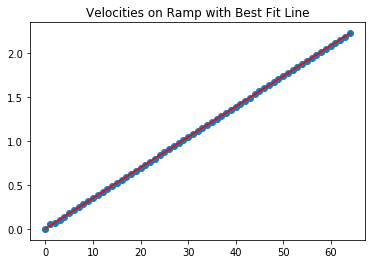

In [11]:
i = find_exit_time(df)
a = fit_line(df, i)

In [12]:
theta = np.pi/4
g = 9.8015
a_theory = g*np.sin(theta)
print("theoretical a is {} compared to calculated a of {}".format(a_theory, a))

theoretical a is 6.930707115799946 compared to calculated a of 6.932653314082638


In [13]:
mu = calc_experimental_mu(a, np.pi/4)
print("The experimental mu is {:0.5f}".format(mu))

The experimental mu is 0.00033


Acceleration checks out, but mu should be 0.

# Test this for Ramp at 30 Degrees

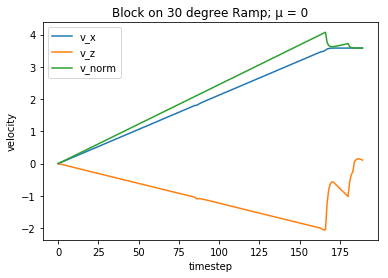

In [14]:
df = edit_df("ramp30velocitiesblock00.txt")
plot_vel_components(df, "30", "0")

Velocity decreasing at timestep 167
Velocity went from 4.0707 to 3.7544
The block fell down the ramp with an acceleration of 4.9046 m/s^2


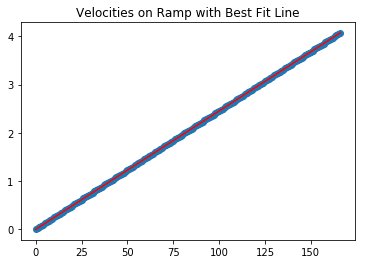

In [15]:
i = find_exit_time(df)
a = fit_line(df, i)

In [17]:
mu = calc_experimental_mu(a, np.pi/6)
print("The experimental mu is {:0.6f}".format(mu))

The experimental mu is 0.000488


# Observe Large Mu for 30 degree Ramp

Let's crank up the friction coefficient to mu = 0.5. Anything larger is too much and seems to prevent the block from sliding to the bottom of the ramp.

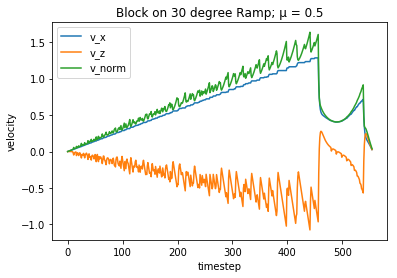

In [22]:
df = edit_df("ramp30velocitiesblock05.txt")
plot_vel_components(df, "30", "0.5")

Increasing coefficient of friction seems to also make the block more bouncy. This seems to be an artifact of the simulator. Let's see if we can minimize this with other params.

# Exploring Solver Parameters

First, let's try changing the cone from pyramidal to elliptic. This is known to handle friction more accurately. 

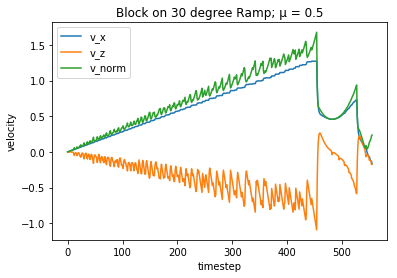

In [23]:
df = edit_df("ramp30velocitiesblock05elliptic.txt")
plot_vel_components(df, "30", "0.5")

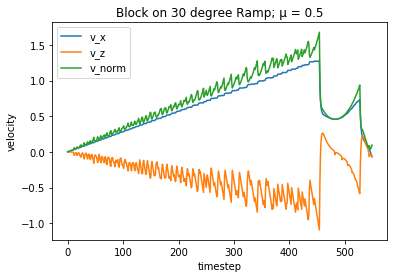

In [24]:
df = edit_df("ramp30velocitiesblock05PGSelliptic.txt")
plot_vel_components(df, "30", "0.5")

## Adjusting SolRef

Reducing first number (recovery time constant) makes contacts harder. solref="0.01 1"

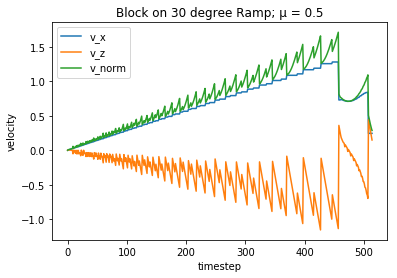

In [25]:
df = edit_df("ramp30velocitiesblock05PGSellipticsolref01.txt")
plot_vel_components(df, "30", "0.5")

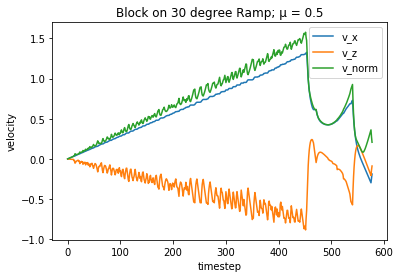

In [26]:
df = edit_df("ramp30velocitiesblock05PGSellipticsolref04.txt")
plot_vel_components(df, "30", "0.5")

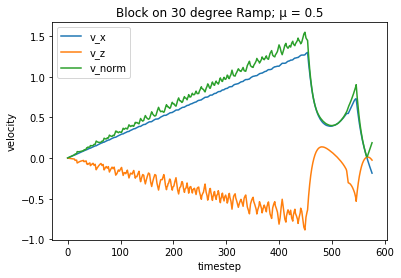

In [27]:
df = edit_df("ramp30velocitiesblock05PGSellipticsolref1.txt")
plot_vel_components(df, "30", "0.5")

# Repeat For Sphere

Sphere starts at same coordinates as block and has diameter = 0.025, which is also width and height of block (depth is 0.05)

In [ ]:
df =  pd.read_csv("velocitiessphere01.txt", header=None)

In [ ]:
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

## Plot it

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.1")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

# Try to Limit Bouncing of Sphere

Taking a closer look at z-component of velocity, we see, it dosn't actually go to exactly zero after it exits the ramp, but rather there is some bouncing effect.

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_z, label="v_z")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.1")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep")
ax.set_xlim(70, 160)
ax.set_ylim(-0.05, 0.15);

In [ ]:
df.iloc[70:95][2]

In [ ]:
df.iloc[110:120][2]

The initial bounce druves the z-component of velocity up to 0.140 at t=74. Then the sphere starts slowing down, but is still travelling upward until t=88. The sphere makes one more bounce, but then hits a resting velocity at t=111

# Turn on Condim = 6 to Provide Rotational Friction

In [ ]:
df =  pd.read_csv("velocitiessphere02.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.1 0.005 0.0001, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

Bouncing is noticeably worse, and does not converge to 0 well after 1000 time steps. Try increasing other friction components.

# Increase All Friction Params and Ball stops, but still bounces

In [ ]:
df =  pd.read_csv("velocitiessphere03.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.2 0.05 0.01, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

Indeed, bouncing seems worse here. Sphere even bounces as it falls down ramp. Let's actually decrease rotational and torsional frictions.

In [ ]:
df =  pd.read_csv("velocitiessphere04.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.2 0.05 0.00001, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

Let's try to eliminate bouncing on the ramp

In [ ]:
df =  pd.read_csv("velocitiessphere05.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.2 0.005 0.00001, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");

# Try Placing Primitive Pupper on the Ramp

In [ ]:
df =  pd.read_csv("velocitiesprimitivepupper.txt", header=None)
step = df.index.values
v_x = df[0].apply(lambda x: float(x.strip('gvel: '))).values
v_z = df[2].apply(float).values
df[3] = np.sqrt(v_x**2 + v_z**2)
v = df[3].values

In [ ]:
fig, ax = plt.subplots()
ax.plot(step, v_x, label="v_x")
ax.plot(step, v_z, label="v_z")
ax.plot(step, v, label="v_norm")
ax.legend()
ax.set_title("Sphere on Ramp Velocities μ = 0.2 0.005 0.00001, Condim=6")
ax.set_ylabel("velocity")
ax.set_xlabel("timestep");